In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
import pickle

In [2]:
(X_train,y_train),(X_test,y_test) = mnist.load_data()

In [3]:
X_train = X_train.reshape(X_train.shape[0],1,28*28)
X_train = X_train.astype(np.float64)
X_train /= 255
X_train = X_train.squeeze()
X_test = X_test.reshape(X_test.shape[0],1,28*28)
X_test = X_test.astype(np.float64).squeeze()
X_test /= 255

In [4]:
class Layer:
    def __init__(self):
        # initialize inputs, outputs to None
        self.inputs = None
        self.outputs = None

    def forward_Pass(self, X, y):
        pass

    def backward(self, X, y):
        pass

In [5]:
class LinearLayer(Layer):
  def __init__(self, inputs,outputs,range = None):
      super().__init__()
      if range == None:
        self.weights = np.zeros((outputs, inputs))
        self.bias = np.zeros((outputs))
      else:
        self.weights = (np.random.rand(outputs,inputs) * 2 * range) - range
        self.bias = np.random.rand(outputs) - 0.5

  def forward_pass(self, X):
      self.X = X
      self.outputs = ((self.weights @ self.X.T).T + self.bias)
      return self.outputs

  def backward(self, err_outputs, alpha):
    error = err_outputs @ self.weights
    self.w_error = err_outputs.T @ self.X
    self.weights = self.weights - (alpha*self.w_error)
    self.bias = self.bias-(alpha*err_outputs)
    return error

In [6]:
class Sigmoid(Layer):
  def __init__(self):
      super().__init__()

  def forward_pass(self,inputs):
    self.inputs = 1.0/(1.0+np.exp(-inputs))
    return self.inputs
    
  def backward(self,err_outputs,alpha):
    return self.inputs * (1 - self.inputs) * err_outputs

In [7]:
class Tanh(Layer):
  def __init__(self):
      super().__init__()
      
  def forward_pass(self,inputs):
    self.inputs = np.tanh(inputs)
    return self.inputs

  def backward(self,err_outputs,alpha):
    return (1 - self.inputs**2) * err_outputs

In [8]:
class Softmax(Layer):
  def __init__(self):
      super().__init__()

  def forward_pass(self, inputs):
      exps = np.exp(inputs - inputs.max())
      return exps / np.sum(np.exp(exps), axis=0, keepdims=True)

  def backward(self, err_outputs, alpha):
    #derivative already computed with CrossEntropyLoss
    return err_outputs

In [9]:
class CrossEntropyLoss(Layer):
  def __init__(self):
      super().__init__()

  def forward_pass(self,y,y_pred):
    return -y * np.log(y_pred)

  def backward(self,y,y_pred):
    return y_pred - y

In [10]:
# Define a Sequential class that extends the Layer class
class Sequential(Layer):
    def __init__(self):
        super().__init__()
        self.layers_list = []  # List of layers in the neural network
        self.loss = None       # Loss function to calculate error
        self.errors = []       # List to store errors at each epoch
        self.val_errors = []   # List to store validation errors at each epoch



    # Add a layer to the neural network
    def add_layer(self, layer):
        self.layers_list.append(layer)

    # Set the loss function for the neural network
    def set_loss(self, loss_function):
        self.loss = loss_function
    def fit(self, X_train, y_train, epochs=10, learning_rate=0.01, X_val=None, y_val=None):
        self.learning_rate = learning_rate
        n_samples = X_train.shape[0]
        epoch_count = 0
        total_errors = list()
        val_errors = list()
        
        if X_val is not None and y_val is not None:
            val_n_samples = X_val.shape[0]

        for i in range(epochs):
            
            total_error = 0
        
            for j in range(n_samples):
                # Get the predicted output for the current input
                y_pred = X_train[j]
                if (y_pred.ndim == 1):
                    y_pred = y_pred[None, :]
                
                # Forward Propagation: apply each layer in the neural network to the current input
                for layer in self.layers_list:
                    y_pred = layer.forward_pass(y_pred)
                
                # Error calculation: calculating the error between the predicted output and the actual output
                total_error += np.sum(np.mean(self.loss.forward_pass(y_train[j], y_pred), axis=0))
                output_error = np.array(self.loss.backward(y_train[j], y_pred))
                
                # Backward Propagation: propagate the error back through the neural network and update the weights
                for layer in reversed(self.layers_list):
                    output_error = layer.backward(output_error, learning_rate)
            
            epoch_count += 1
            
            # Calculating the average error for the current epoch and store it in the errors list
            total_error = total_error/n_samples
            self.errors.append(round(total_error,6))
            
            if X_val is not None and y_val is not None:
                # Evaluate the validation set and calculate the validation error
                val_error = 0
                for k in range(val_n_samples):
                    val_pred = X_val[k]
                    if (val_pred.ndim == 1):
                        val_pred = val_pred[None, :]
                        
                    for layer in self.layers_list:
                        val_pred = layer.forward_pass(val_pred)
                    
                    val_error += np.sum(np.mean(self.loss.forward_pass(y_val[k], val_pred), axis=0))
                
                val_error = val_error/val_n_samples
                self.val_errors.append(round(val_error, 6))
            
            # Early Stopping: stop training if the error has not improved in the last 5 epochs
            if epoch_count > 5 and all(a == self.errors[-1:] for a in self.errors[-5:]):
                break
            
            print('epoch %d----> train error: %f'%(i+1, total_error))
            if X_val is not None and y_val is not None:
                print('epoch %d----> val error: %f'%(i+1, val_error))

        if X_val is not None and y_val is not None:
            return self.errors, self.val_errors
        else:
          return self.errors

    # Use the trained neural network to predict the outputs for a given dataset
    def predict(self, X_test, probability = False):
        n_samples = X_test.shape[0]
        y_pred_matrix = []
        y_pred = []
        for i in range(n_samples):
            out = X_test[i]

            # Forward Propagation: apply each layer in the neural network to the current input
            for layer in self.layers_list:
                out = layer.forward_pass(out)
            y_pred_matrix.append(out)

        if probability:
            # Return the probability distribution of the predicted outputs
            return y_pred_matrix

        # Round the output probabilities to get binary outputs
        for i in y_pred_matrix:
            i[i > 0.5] = 1
            i[i < 0.5] = 0

        # Return the binary outputs as an array
        return np.array(y_pred_matrix)

    def plot_errors(self):
        # assuming you have already called the `fit` method and saved the errors
        # in the `self.errors` and `val_errors` variables
        epochs = len(self.errors)

        # plot the errors
        plt.plot(range(1, epochs+1), self.errors, label='Training error')
        if len(self.val_errors) > 0:
            plt.plot(range(1, epochs+1), self.val_errors, label='Validation error')

        # add labels and legend
        plt.xlabel('Epochs')
        plt.ylabel('Error')
        plt.legend()

        # show the plot
        plt.show()

In [11]:
data = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
target = np.array([[0], [1], [1], [0]])

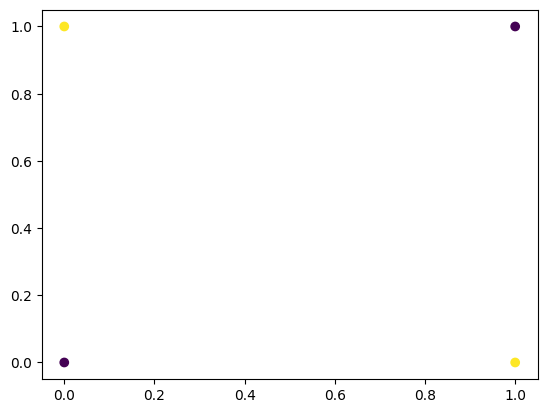

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1], c = target)

In [13]:
X_val = np.array([[0,0], [0,1], [1,0], [1,1]])
y_val = np.array([0, 1, 1, 0])

In [14]:
# Create a Sequential neural network
first = Sequential()
# Add the first layer (input layer)
first.add_layer(LinearLayer(2,2,2))
first.add_layer(Sigmoid())
# Add the second layer (output layer)
first.add_layer(LinearLayer(2,1,2))
first.add_layer(Sigmoid())
# set the loss function
first.set_loss(CrossEntropyLoss())

In [15]:
first.fit(data,target,10,0.01, X_val=X_val, y_val=y_val)

epoch 1----> train error: 0.679772
epoch 1----> val error: 0.678367
epoch 2----> train error: 0.678325
epoch 2----> val error: 0.676922
epoch 3----> train error: 0.676882
epoch 3----> val error: 0.675480
epoch 4----> train error: 0.675441
epoch 4----> val error: 0.674042
epoch 5----> train error: 0.674004
epoch 5----> val error: 0.672607
epoch 6----> train error: 0.672570
epoch 6----> val error: 0.671175
epoch 7----> train error: 0.671139
epoch 7----> val error: 0.669747
epoch 8----> train error: 0.669712
epoch 8----> val error: 0.668321
epoch 9----> train error: 0.668288
epoch 9----> val error: 0.666900
epoch 10----> train error: 0.666867
epoch 10----> val error: 0.665481


([0.679772,
  0.678325,
  0.676882,
  0.675441,
  0.674004,
  0.67257,
  0.671139,
  0.669712,
  0.668288,
  0.666867],
 [0.678367,
  0.676922,
  0.67548,
  0.674042,
  0.672607,
  0.671175,
  0.669747,
  0.668321,
  0.6669,
  0.665481])

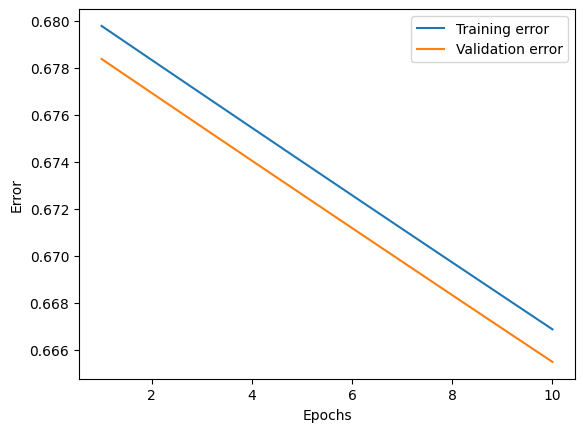

In [16]:
first.plot_errors()

In [17]:
with open('xor_solved.pkl', 'wb') as outp:
    pickle.dump(first, outp, pickle.HIGHEST_PROTOCOL)

In [18]:
# Create a Sequential neural network
second = Sequential()
# Add the first layer (input layer)
second.add_layer(LinearLayer(2,2,2))
second.add_layer(Tanh())
# Add the second layer (output layer)
second.add_layer(LinearLayer(2,1,2))
second.add_layer(Sigmoid())
# Set the loss function
second.set_loss(CrossEntropyLoss())
second.fit(data,target,10,0.001, X_val=X_val, y_val=y_val)

epoch 1----> train error: 0.389033
epoch 1----> val error: 0.389016
epoch 2----> train error: 0.389049
epoch 2----> val error: 0.389032
epoch 3----> train error: 0.389065
epoch 3----> val error: 0.389048
epoch 4----> train error: 0.389081
epoch 4----> val error: 0.389064
epoch 5----> train error: 0.389098
epoch 5----> val error: 0.389081
epoch 6----> train error: 0.389114
epoch 6----> val error: 0.389097
epoch 7----> train error: 0.389130
epoch 7----> val error: 0.389113
epoch 8----> train error: 0.389146
epoch 8----> val error: 0.389129
epoch 9----> train error: 0.389162
epoch 9----> val error: 0.389145
epoch 10----> train error: 0.389178
epoch 10----> val error: 0.389161


([0.389033,
  0.389049,
  0.389065,
  0.389081,
  0.389098,
  0.389114,
  0.38913,
  0.389146,
  0.389162,
  0.389178],
 [0.389016,
  0.389032,
  0.389048,
  0.389064,
  0.389081,
  0.389097,
  0.389113,
  0.389129,
  0.389145,
  0.389161])



The error is slightly low with Tanh than Sigmoid but the difference is too low to say anything for sure 





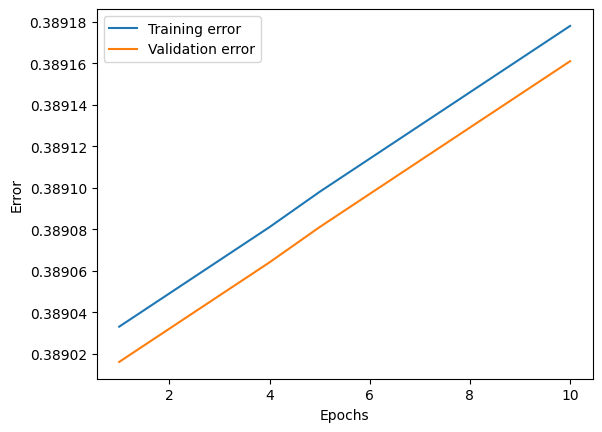

In [19]:
second.plot_errors()

In [20]:
print(second.val_errors)


[0.389016, 0.389032, 0.389048, 0.389064, 0.389081, 0.389097, 0.389113, 0.389129, 0.389145, 0.389161]


In [21]:
def get_one_hot(target, nb_classes):
    res = np.eye(nb_classes)[np.array(target).reshape(-1)]
    return res.reshape(list(target.shape)+[nb_classes])

In [22]:
y_train =  get_one_hot(y_train.astype(int), 10)
y_test = get_one_hot(y_test.astype(int), 10)

In [ ]:
# Sequential
first = Sequential()
# the first layer(input layer)
first.add_layer(LinearLayer(28*28,64))
first.add_layer(Tanh())
#output layer
first.add_layer(LinearLayer(64,10))
first.add_layer(Sigmoid())
# Set the loss function
first.set_loss(CrossEntropyLoss())
# fit
first.fit(X_train,y_train,4,0.001, X_val=X_train, y_val=y_train)


In [ ]:
y_pred = first.predict(X_test)

In [ ]:
print(f'Accuracy of model the first : {round(np.mean(y_pred == y_test)*100,2)} %')

In [ ]:
first.plot_errors()

In [ ]:
# sequential
model_second = Sequential()
#first layer
model_second.add_layer(LinearLayer(28*28,100,10))
model_second.add_layer(Tanh())
#second layer
model_second.add_layer(LinearLayer(100,10,10))
model_second.add_layer(Sigmoid())
# Set the loss function
model_second.set_loss(CrossEntropyLoss())
#fit
model_second.fit(X_train,y_train,4,0.0001, X_val=X_train, y_val=y_train)

In [ ]:
predicted = model_second.predict(X_test)
print(f'Accuracy of model the second : {round(np.mean(predicted == y_test)*100,2)} %')

In [ ]:
model_second.plot_errors()

In [ ]:
# sequential
model_third = Sequential()
#first layer
model_third.add_layer(LinearLayer(28*28,100,1))
model_third.add_layer(Tanh())
#third layer
model_third.add_layer(LinearLayer(100,10,1))
model_third.add_layer(Sigmoid())
# Set the loss function
model_third.set_loss(CrossEntropyLoss())
#fit
model_third.fit(X_train,y_train,4,0.001, X_val=X_train, y_val=y_train)

In [ ]:
predicted = model_third.predict(X_test)
print(f'Accuracy of model the third : {round(np.mean(predicted == y_test)*100,2)} %')

In [ ]:
model_third.plot_errors()

In [ ]:
# sequential
model_fourth = Sequential()
#first layer
model_fourth.add_layer(LinearLayer(28*28,100,1))
model_fourth.add_layer(Tanh())
#fourth layer
model_fourth.add_layer(LinearLayer(100,10,1))
model_fourth.add_layer(Sigmoid())
# Set the loss function
model_fourth.set_loss(CrossEntropyLoss())
#fit
model_fourth.fit(X_train,y_train,4,0.001, X_val=X_train, y_val=y_train)

In [ ]:
predicted = model_fourth.predict(X_test)
print(f'Accuracy of model the fourth : {round(np.mean(predicted == y_test)*100,2)} %')

In [ ]:
model_fourth.plot_errors()